<a href="https://colab.research.google.com/github/Abhilasa123/Name_Entity_Recognition/blob/main/name_Entity_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install keras==2.3.0

     |████████████████████████████████| 378kB 2.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
import tensorflow as tf
 
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector

# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 1
    MAX_LEN = 75
    EMBEDDING = 20


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)
print("words:", words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  47959
Number of words in the dataset:  35178
words: ['Ajmal', 'landmines', 'Reese', 'Abduction', 'Gush', 'negligent', 'Elvis', 'Katarina', 'UNAMID', 'cessation', 'Gupta', 'fight', 'Plachkov', 'willingness', 'UN-sponsored', 'Orinoco', 'Shanksville', 'grips', 'Uninsured', 'notoriety', 'bride-to-be', 'amateur', '18,00', 'gymnasiums', 'rebellions', 'polo', 'NFA', 'Mebki', 'Domenech', 'Velasco', 'novel', 'bad', 'conditioners', 'CERTAIN', 'Sinhalese', 'al-Tahreer', 'Undersecretary-General', '1911', 'Eid-al-Fitr', 'vexation', 'Masri', 'West-leaning', 'hardcourt', 'Sahibzada', 'warm-up', '30', 'collecting', 'Calderon', 'compliments', 'supporter', 'authorize', 'poorly', 'Notices', 'Lagham', 'H7', 'extractive', 'sheeting', 'Acehnese', 'exposing', 'de-miners', 'anniversary', 'benefited', 'Dextre', 'Vaile', 'historical', 'machetes', 'Lama', 'exiles', 'Zhu', '9.72', 'Alloceans', 'looking', 'punishing', 'twice-weekly', 'Livingstone', 'stopover', 'NORIEGA', 'Copts', 'erosion', '

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


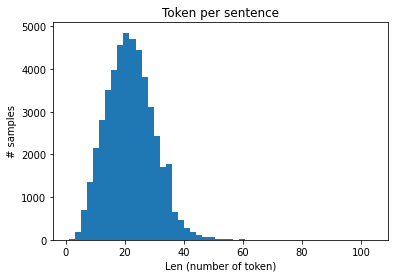

In [ ]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])


The word Obama is identified by the index: 22043
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 1


Using TensorFlow backend.


Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [10938 11343  8907 31511  8255  6890 21710  5860 28154 12412 27091 10472
 22137  3957 15855 12412  4722 11343 34503  7197 13018  9376 10842 28559
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
After processing, labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

     |████████████████████████████████| 747kB 4.0MB/s 


In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, )(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 75, 20)            668540    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_3 (CRF)                  (None, 75, 18)            1278      
Total params: 703,268
Trainable params: 703,268
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=5,
                    validation_split=0.1, verbose=2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 34793 samples, validate on 3866 samples
Epoch 1/1
 - 121s - loss: 0.1258 - crf_viterbi_accuracy: 0.9648 - val_loss: 0.0366 - val_crf_viterbi_accuracy: 0.9836


In [ ]:

# Eval
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        45
       B-eve       0.00      0.00      0.00        23
       B-geo       0.74      0.87      0.80      3396
       B-gpe       0.90      0.83      0.86      1374
       B-nat       0.00      0.00      0.00        13
       B-org       0.62      0.46      0.53      1835
       B-per       0.81      0.53      0.64      1497
       B-tim       0.92      0.66      0.77      1816
       I-art       0.00      0.00      0.00        36
       I-eve       0.00      0.00      0.00        19
       I-geo       0.70      0.68      0.69       699
       I-gpe       0.00      0.00      0.00        12
       I-nat       0.00      0.00      0.00         4
       I-org       0.62      0.50      0.55      1609
       I-per       0.78      0.71      0.74      1520
       I-tim       0.90      0.34      0.49       568
           O       0.97      0.99      0.98     80010
         PAD       1.00    

In [ ]:
i = np.random.randint(0,X_te.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:45}: {:30} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 3743 of 4296 (Test Set)
Word           ||True ||Pred
Police                                       : O                              O
in                                           : O                              O
Rangoon                                      : B-geo                          B-geo
,                                            : O                              O
Burma                                        : B-geo                          B-geo
's                                           : O                              O
largest                                      : O                              O
city                                         : O                              O
,                                            : O                              O
kept                                         : O                              O
close                                        : O                              O
watch                                        

In [ ]:
from ipywidgets import interact_manual
from ipywidgets import widgets
 
import re
import string
 
# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
    
def get_prediction(sentence):
    test_sentence = tokenize(sentence) # Tokenization
    # Preprocessing
    x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=word2idx["PAD"], maxlen=MAX_LEN)
    # Evaluation
    p = model.predict(np.array([x_test_sent[0]]))
    p = np.argmax(p, axis=-1)
    # Visualization
    print("{:15}||{}".format("Word", "Prediction"))
    print(30 * "=")
    for w, pred in zip(test_sentence, p[0]):
        print("{:15}: {:5}".format(w, idx2tag[pred]))
 
interact_manual(get_prediction, sentence=widgets.Textarea(placeholder='Type your sentence here'));

interactive(children=(Textarea(value='', description='sentence', placeholder='Type your sentence here'), Butto…

In [ ]:
import pickle
 
# Saving Vocab
with open('word_to_index.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Vocab
with open('tag_to_index.pickle', 'wb') as handle:
    pickle.dump(tag2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Saving Model Weight
model.save_weights('lstm_crf_weights.h5',)